In [5]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
file = Remote.get_instance().load("examples", "portfolio_allocation.csv", to=None)
df = pd.read_csv(file, parse_dates=True, index_col="date") # aqui são os dados diários dos valores de 20 ações que vamos criar nosso portifólio

In [7]:
returns = df.pct_change().dropna(how="all")# calcula os retornos (pct_change) para todas as colunas, exceto NaN
print('Shapes of returns=',returns.shape)

Shapes of returns= (7125, 20)


In [8]:
returns = df.pct_change().dropna(how="all")
print('Shapes of returns=',returns.shape)
mu = (1 + returns).prod() ** (252 / returns.count()) - 1 
cov = returns.cov() * 252 
mu, cov = mu.to_numpy(), cov.to_numpy()
print('Shapes of mu=',mu.shape,' and cov=',cov.shape)
labels = df.columns
print(len(labels),' Assets=',list(labels))


Shapes of returns= (7125, 20)
Shapes of mu= (20,)  and cov= (20, 20)
20  Assets= ['GOOG', 'AAPL', 'FB', 'BABA', 'AMZN', 'GE', 'AMD', 'WMT', 'BAC', 'GM', 'T', 'UAA', 'SHLD', 'XOM', 'RRC', 'BBY', 'MA', 'PFE', 'JPM', 'SBUX']


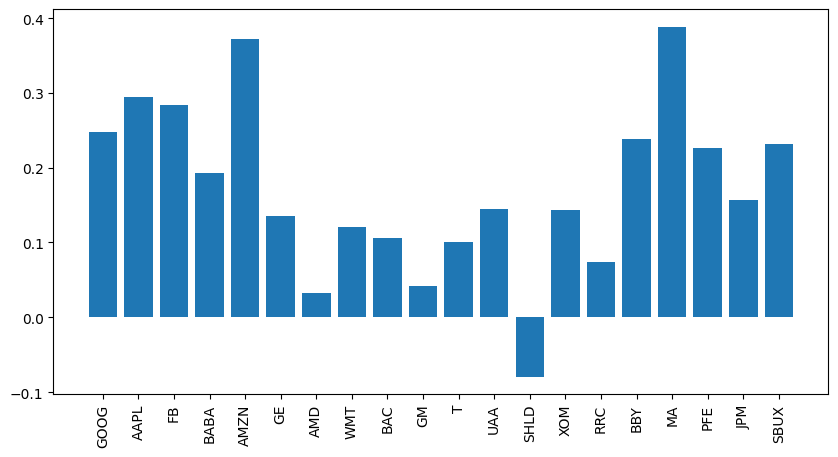

In [9]:
#Plota o retorno médio percentual anual de cada um dos ativos que estou lidando

fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()

DONE


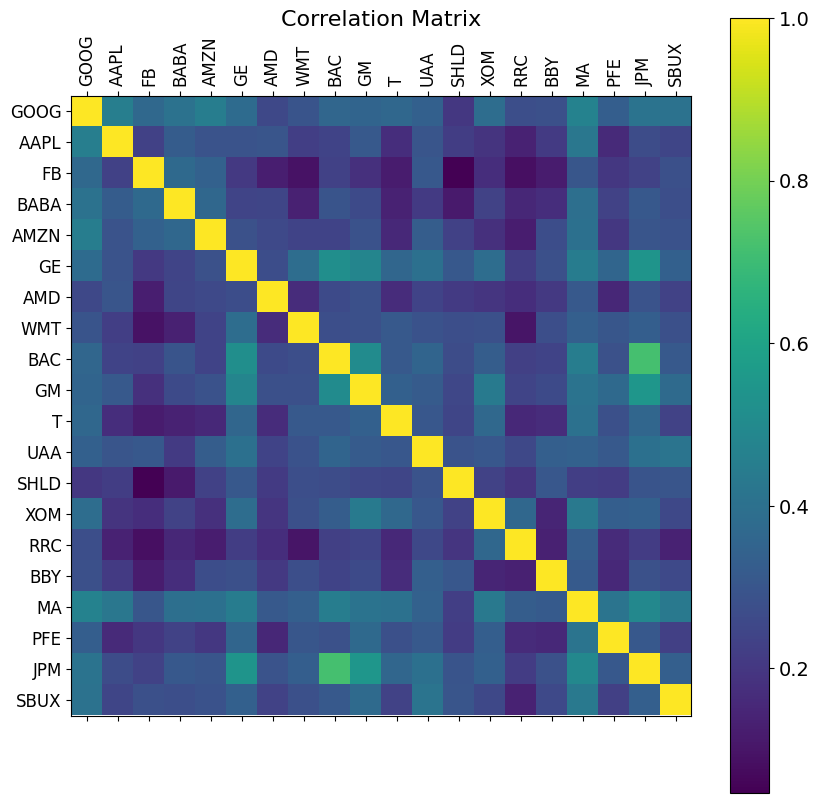

In [10]:
# Matriz de Correlação de Retornos
f = plt.figure(figsize=(10, 10))
plt.matshow(returns.corr(), fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
print("DONE")

In [12]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(df.columns), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]
